# **Day5 실습에 오신것을 환영합니다**




이번 시간에 실습해볼 주제는 Image captioning입니다.


Image captioning은 이미지를 입력으로 넣었을 때 대응되는 텍스트를 출력하는 task입니다.

전체적인 구조는 아래와 같습니다. 이미 학습이 완료된 CNN모델은 이미지 인코더로 각각의 사물이 어떤 위치에 존재하는가에 관한 spatial한 정보를 압축하여 feature vector의 형태로 만듭니다. 이 feature vector와 word embedding을 입력으로 넣어주어 디코더(LSTM들로 구성된 부분)를 학습시키게 됩니다.

학습이 완료된 디코더는 이미지의 feature vector와 현재까지 업데이트 된 word embedding을 통해 적절한 다음 단어를 예측하는 방식으로 문장을 구성합니다.

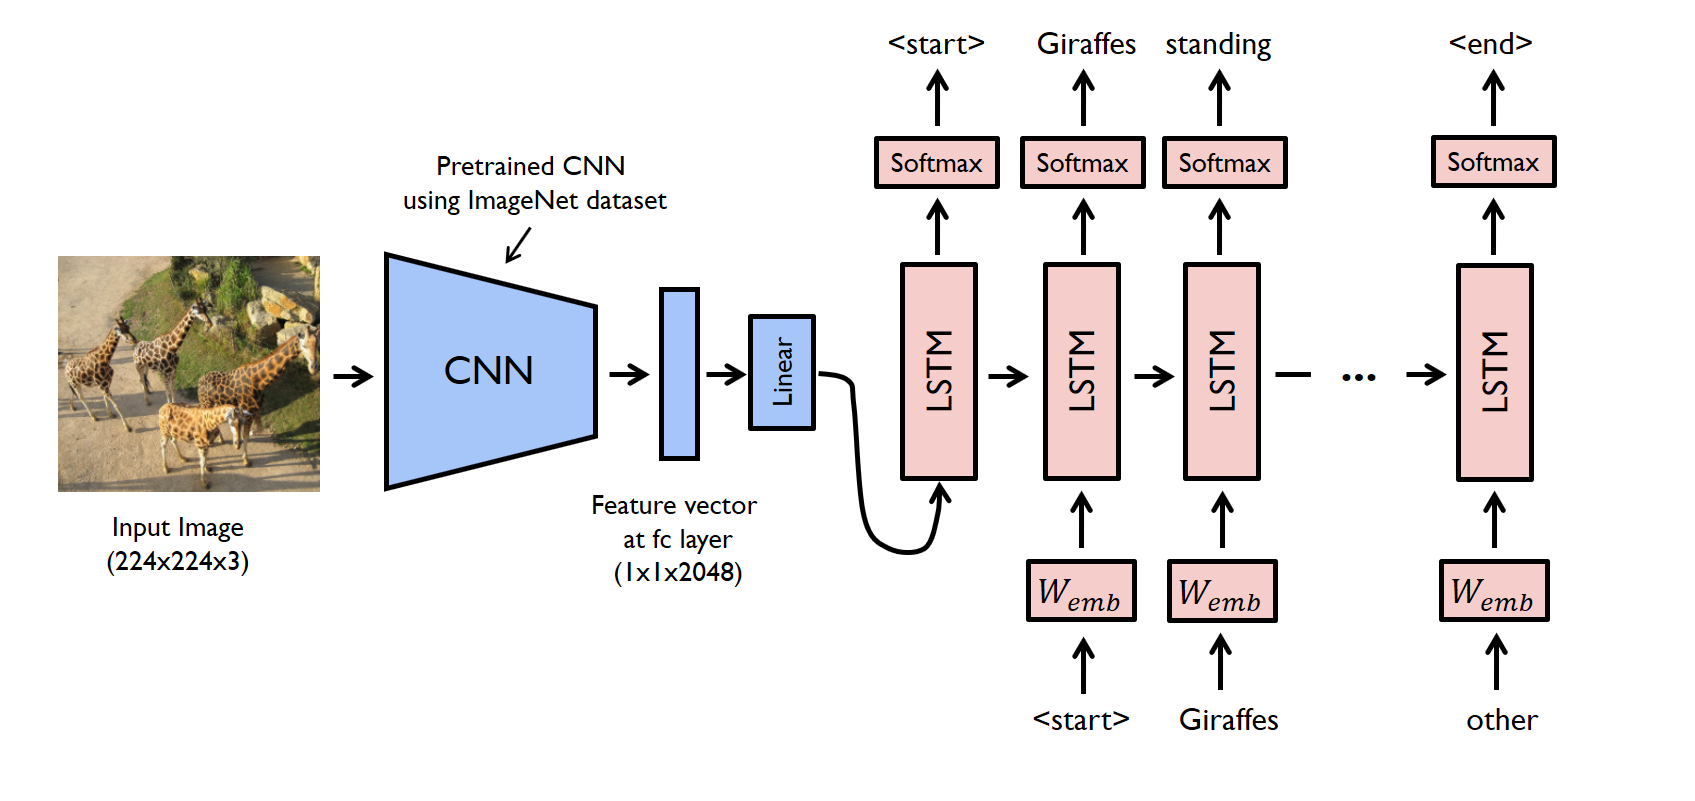

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#<models>
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

## 1. Image encoder

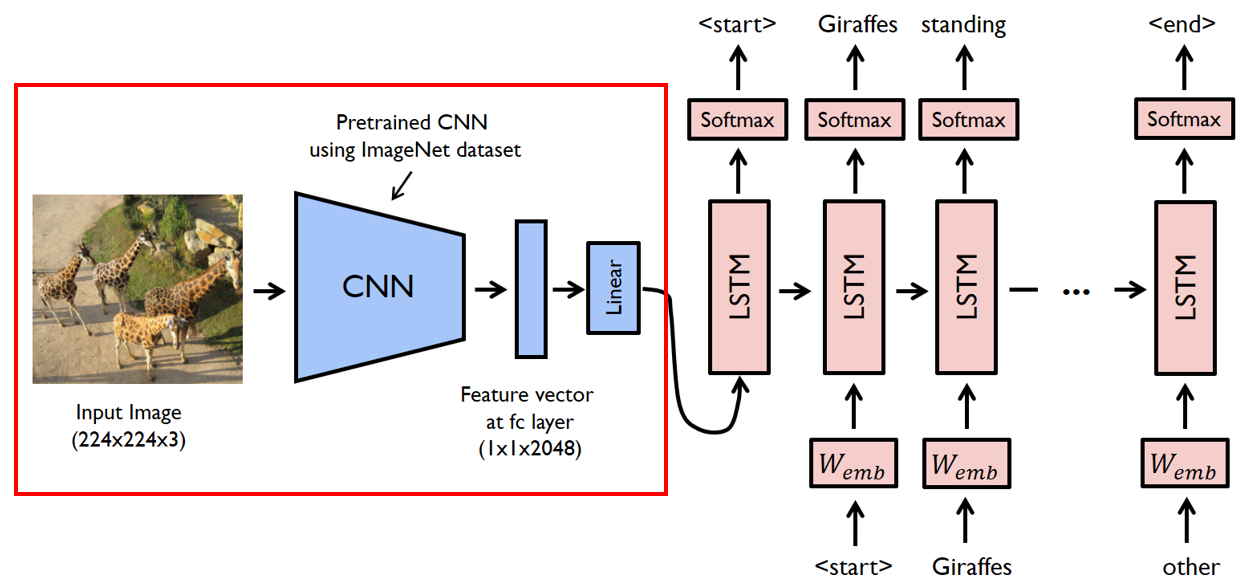

CNN Encoder를 통해 이미지 feature를 뽑아내는 모델을 만들어 봅시다. Pretrained 된 resnet-152 model을 사용할 예정입니다.  
TODO 를 구현해주세요

In [17]:
class EncoderCNN(nn.Module):

    def __init__(self, embed_size):

        super(EncoderCNN, self).__init__()
        # [Do it yourself] 학습이 완료된 ResNet-152에서 fully connected layer의 가장 마지막 layer를 제거한 후 새로운 모델을 구성합니다.
        # Hint: https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch
        # Pretrained 된 모델에서 feature을 뽑을 때 사용하는 방법으로 감이 잡히지 않는 분들은 위의 링크를 참조하세요!
        # 등장하는 asterisk(*)는 Unpacking 하여 layer별로 분리하는 역할을 담당합니다

        resnet = models.resnet152(pretrained = True)
        modules = list(resnet.children())[:-1] # fully connected layer의 가장 마지막 layer 제거
        self.resnet = nn.Sequential(*modules)

        # 마지막 layer를 제거한 resnet에서 뽑아낸 feature를 fully connected layer를 붙여 embed_size vector가 출력이 되도록 합니다.
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

        # [Do it yourself] LSTM에 넣어줄 input은 vector형태이므로 1D Batch normalization을 해줍니다.
        # nn.BatchNorm1d를 사용하시고 momentum은 0.01로 해주세요
        self.bn = nn.BatchNorm1d(embed_size, momentum = 0.01)

    def forward(self, images):

        # 입력 이미지로부터 feature vector를 뽑아냅니다
        with torch.no_grad():

            features = self.resnet(images)

        features = features.reshape(features.size(0),-1)
        features = self.bn(self.linear(features))

        return features



## 2. Text decoder

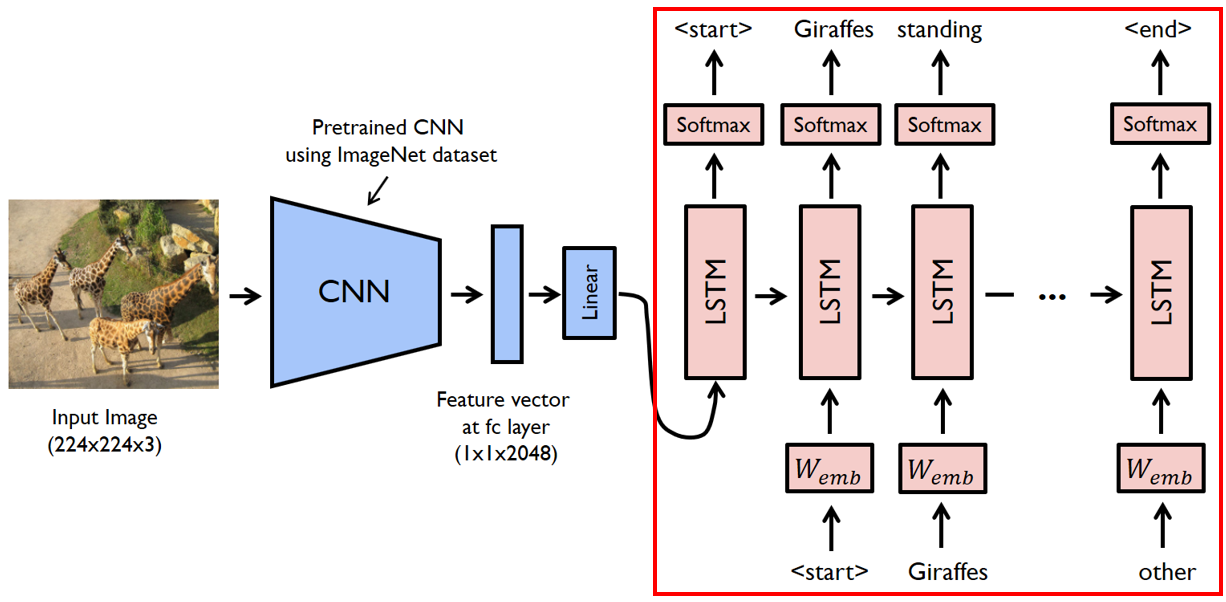

이번에는 LSTM Decoder를 만들어보도록 하겠습니다.

In [15]:
class DecoderRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length = 20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()

        # [Do it yourself] 단어의 개수(vocab_size)와 단어를 표현할 벡터의 차원크기(embed_size)를 입력으로 받아 참조 테이블을 만듭니다.
        # 자세한 것은 아래의 링크를 읽어보세요 (nn.Embedding관련)
        # 1번링크 : https://tutorials.pytorch.kr/beginner/nlp/word_embeddings_tutorial.html
        # 2번링크 : https://wikidocs.net/64779
        self.embed = nn.Embedding(vocab_size, embed_size)

        # [Do it yourself] LSTM layer를 구성해봅시다.
        # https://sanghyu.tistory.com/52
        # 해당 링크에 등장하는 nn.LSTM의 입력 파라미터 중 input_size, hidden_size, num_layers, batch_first가
        # 현재 상황에서는 어떤 변수들과 매칭이 되는지 판단하여 넣어주세요
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True)

        # [Do it yourself] fully connected layer를 거쳐 어떤 많은 단어들 중 어떤 단어가 뒤에 오면 좋을지 판단해야 하므로
        # 단어의 개수(vocab_size)가 출력의 dimension이 됩니다.
        self.linear = nn.Linear(hidden_size, vocab_size)

        # 문장 안의 단어 sequence의 최대 길이 제한을 위함
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):

        # Image feature vector들을 Decoding 하고 caption들을 생성합니다
        # 현재까지 생성한 captions를 Embedding한 후 이미지 feature와 concat 시켜 다시 입력으로 넣습니다.
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        # pack_padded_sequence는 lstm의 input parameter들을 묶어주는 역할을 합니다.
        packed = pack_padded_sequence(embeddings, lengths, batch_first = True)

        # lstm의 출력은 https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html 을 참고하세요!
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])

        return outputs

    def sample(self, features, states = None):

        # 학습이 완료된 상태에서 이미지만 넣었을때 문장이 나오도록 해봅시다
        # 주어진 image feature들을 greedy search방법으로 caption들을 생성합니다.
        # Greedy search란? - https://ko.wikipedia.org/wiki/%ED%83%90%EC%9A%95_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98

        sampled_ids = []
        inputs = features.unsqueeze(1)  # (1,256) -> (1,1,256)

        for i in range(self.max_seq_length):

            # [Do it yourself] 이미지에서 추출한 feature를 input으로 우선 넣은 후 연관성이 높은 단어를 예측합니다.(이때의 lstm의 입력 states = None입니다.)
            # 이때의 출력 states에는 tuple 형태로 2가지를 담고 있습니다. states = (hidden state의 상태, cell state의 상태)이것과 출력으로 나온 단어를
            # 통해 다음에 나올 적절한 단어를 예측하게 됩니다.
            # 하단의 ?에 들어가면 좋을 변수들을 선정하여 채워주세요 (힌트 : LSTM은 출력을 다시 입력으로 받으며, 기존의 상태는 states에 저장합니다.)

            # hiddens: (batch_size, 1, hidden_size) == (1, 1, 512)
            # states: ([1,1,512], [1,1,512])
            hiddens, states = self.lstm(inputs, states)

            # Hidden layer의 결과를 Fully connected layer를 통해 가장 큰 값을 가지는 단어를 추정합니다.
            # outputs:  (batch_size, vocab_size) == (1, 9956)
            outputs = self.linear(hiddens.squeeze(1))

            # [Do it yourself] 수천개의 단어들 중에서 가장 큰 값을 가지는 단어의 argmax 위치만 필요합니다. 출력에서 max값을 가지는 위치를 뽑아주세요.
            # 자세한 사항은 다음을 참고하세요 https://wikidocs.net/52460 (힌트 : max를 이용하고 적당한 axis를 찾아주세요)
            _, predicted = outputs.max(1)

            # [Do it yourself] argmax위치의 단어(predicted)를 기존에 선택된 단어집(sampled_ids)에 추가(append 함수 이용)
            sampled_ids.append(predicted)

            #현재 만들어진 단어를 기반으로 다음 단어 예측을 위해 워드임베딩을 하여 다음 input으로 넣어줄 준비를 합니다.

            inputs = self.embed(predicted) # inputs: (batch_size, embed_size) == (1, 256)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)

        # sampled_ids: (batch_size, max_seq_length)
        sampled_ids = torch.stack(sampled_ids,1)

        return sampled_ids


## 3. Data prepare

In [5]:
#<build_vocab>
import nltk
nltk.download('punkt')
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO
import sys
sys.argv=['']
del sys

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


이번 시간에 필요한 것들은 하단의 링크에서 모두 다운받으실 수 있습니다.


모두 다운받아 내 드라이브 > saffy > materials 디렉토리를 생성하여 파일들을 저장해주세요

(원하는 위치에 파일들을 위치하셔도 무방합니다!)

https://drive.google.com/drive/folders/1uMnJGs5GPpqvZYHT8pcZJZ5kyOXEl7zx?usp=sharing

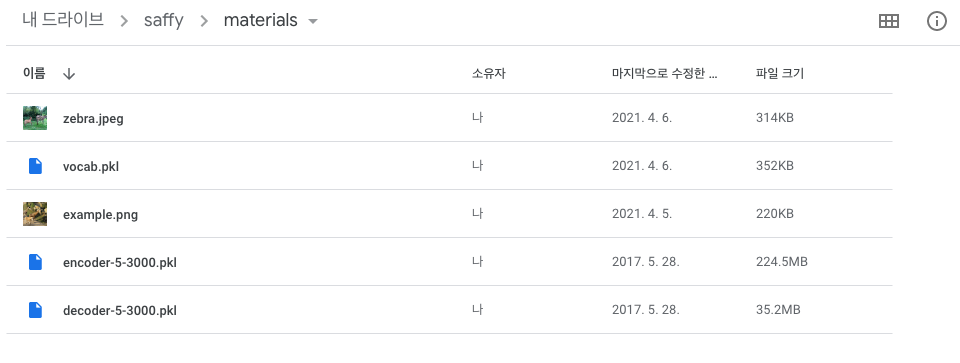

## 4. Build vocab.
디코더 word 예측에 사용할 vocabulary set을 만듭니다.
해당 내용은 실습 범위를 벗어나므로 실행하고 넘어가면 됩니다.

In [6]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [7]:
def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # Word의 등장 빈도가 일정 수준('threshold')이하일 경우 버림
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # 문장의 처음과 끝 등..의 special token들을 추가
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # vocabulary에 word들 추가
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

# 5. Main
pre-trained model을 불러오고 원하는 이미지를 넣어서 이미지 캡셔닝 결과 확인하기

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
from torchvision import transforms
from PIL import Image

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
#임의의 이미지를 넣어도 224x224로 변환합니다.
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

In [13]:
def main(img_path):
    image_input = img_path

    encoder_path = '/content/drive/MyDrive/ssafy/materials/encoder-5-3000.pkl'
    decoder_path = '/content/drive/MyDrive/ssafy/materials/decoder-5-3000.pkl'
    vocab_path = '/content/drive/MyDrive/ssafy/materials/vocab.pkl'
    embed_size = 256
    hidden_size = 512
    num_layers = 1

    # 왜 normalization이 필요한지 궁금하다면 하단의 링크를 확인하세요
    # https://89douner.tistory.com/42
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # vocabulary wrapper로 Load
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # model들을 build
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # train이 완료된 모델의 parameter들 로드
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # 입력으로 넣을 image 준비
    image = load_image(image_input, transform)
    image_tensor = image.to(device)

    # image에서 caption생성
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

    # word index에서 words로 변환하여 문장화
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)

    # 이미지와 캡셔닝 된 문장 결과 출력
    print(sentence)
    image = Image.open(image_input)
    plt.imshow(np.asarray(image))


In [ ]:
image = load_image(image_input, transform)
image_tensor = image.to(device)

feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

print(sentence)
image = Image.open(image_input)
plt.imshow(np.asarray(image))


<start> a brown and white bird is standing on a tree branch . <end>


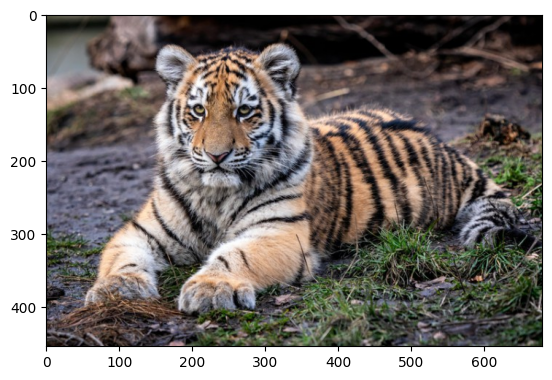

In [19]:
# 본인이 원하는 동물의 이미지를 다운 받아 입력으로 넣어보면서 어떤 결과가 나오는지 확인하여 봅시다
main('/content/animal2.jpg')